In [26]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from dops import *
warnings.filterwarnings('ignore')

In [27]:
with open('./Data/states_bpleq65.p','rb') as f:
    states = pickle.load(f)

In [28]:
patient_ids = list(states.keys())

In [29]:
mini_patient = patient_ids[:1000]

In [114]:
pid = patient_ids[0]
df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
      
                                                        
                                                        
                                                        'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                            'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                             'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind','urine_ind','wbc_ind'])]

df_clean.insert(0,'ICU_ID',pid)
df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
df_y_train = df_clean[['sofa','oasis','saps']]

x_train = df_x_train.iloc[0]
y_train = df_y_train.iloc[0]


for pid in patient_ids[1:]:
    df_clean = states[pid].loc[:,~states[pid].columns.isin(['Times','bicarbonate_ind', 'bun_ind','creatinine_ind',
                                             'fio2_ind','glucose_ind','hct_ind','hr_ind','lactate_ind',
                                            'magnesium_ind','meanbp_ind','platelets_ind','potassium_ind',
                                             'sodium_ind','spo2_ind','spontaneousrr_ind','temp_ind','urine_ind','wbc_ind'])]
    
    df_clean.insert(0,'ICU_ID',pid)
    df_x_train = df_clean.loc[:,~df_clean.columns.isin(['sofa','oasis','saps'])]
    df_y_train = df_clean[['sofa','oasis','saps']]
    
    x_train = pd.concat([x_train,df_x_train.iloc[0]],axis=1)
    y_train = pd.concat([y_train,df_y_train.iloc[0]],axis=1)

In [115]:
x_train = x_train.T.reset_index(drop=True)
y_train = y_train.T.reset_index(drop=True)

In [37]:
corr_df = x_train.drop(['ICU_ID'],axis=1)
corr = corr_df.corr()

In [127]:
corr

,age,is_F,weight,surg_ICU,is_not_white,is_emergency,is_urgent,hrs_from_admit_to_icu,bicarbonate,bun,...,magnesium,meanbp,platelets,potassium,sodium,spo2,spontaneousrr,temp,urine,wbc
age,1.000000,0.109126,-0.187078,-0.073283,-0.088023,0.057241,-0.003368,-0.044161,0.032949,0.136856,...,0.004366,-0.031428,-0.005977,0.047130,0.042847,-0.000135,0.015986,-0.032004,-0.017073,-0.008254
is_F,0.109126,1.000000,-0.259883,-0.065285,0.016332,0.033321,0.006128,-0.027789,-0.011121,-0.057222,...,-0.020733,-0.016264,0.088267,-0.113056,0.014797,-0.004342,0.005248,-0.034222,-0.000495,0.012152
weight,-0.187078,-0.259883,1.000000,0.009041,-0.009096,-0.047079,0.011968,0.005540,0.049432,0.017612,...,0.007538,0.011983,-0.039100,0.057337,-0.007765,-0.034777,0.010274,0.044819,0.015783,0.018920
surg_ICU,-0.073283,-0.065285,0.009041,1.000000,-0.019823,-0.284317,-0.025962,0.016883,0.075643,-0.203550,...,-0.001981,0.018206,-0.013316,0.003580,0.026979,0.087530,-0.073644,0.030297,-0.057513,-0.016113
is_not_white,-0.088023,0.016332,-0.009096,-0.019823,1.000000,0.075226,-0.007769,-0.000554,-0.046291,0.003553,...,-0.000641,0.035192,-0.007403,-0.011931,0.032114,0.027642,0.005859,0.004925,0.000452,0.003059
is_emergency,0.057241,0.033321,-0.047079,-0.284317,0.075226,1.000000,-0.244773,-0.008973,-0.077687,0.088885,...,0.027889,-0.015745,0.101302,-0.084374,0.014624,-0.010731,0.077672,0.032055,0.009719,0.056082
is_urgent,-0.003368,0.006128,0.011968,-0.025962,-0.007769,-0.244773,1.000000,0.012720,-0.011465,0.012321,...,-0.017625,-0.008429,-0.022543,-0.001627,-0.015812,-0.028666,-0.017750,-0.024858,0.026245,-0.003813
hrs_from_admit_to_icu,-0.044161,-0.027789,0.005540,0.016883,-0.000554,-0.008973,0.012720,1.000000,0.040889,0.096752,...,-0.013401,-0.032468,0.011670,0.010775,-0.040034,-0.073669,0.103640,-0.043442,0.049887,-0.022674
bicarbonate,0.032949,-0.011121,0.049432,0.075643,-0.046291,-0.077687,-0.011465,0.040889,1.000000,-0.197945,...,0.028198,0.032539,0.029637,-0.092072,0.115025,-0.013714,-0.038843,0.034983,0.032258,-0.146713
bun,0.136856,-0.057222,0.017612,-0.203550,0.003553,0.088885,0.012321,0.096752,-0.197945,1.000000,...,0.116389,-0.082670,-0.051184,0.282569,-0.009714,-0.043446,0.039095,-0.066756,-0.038508,0.098102


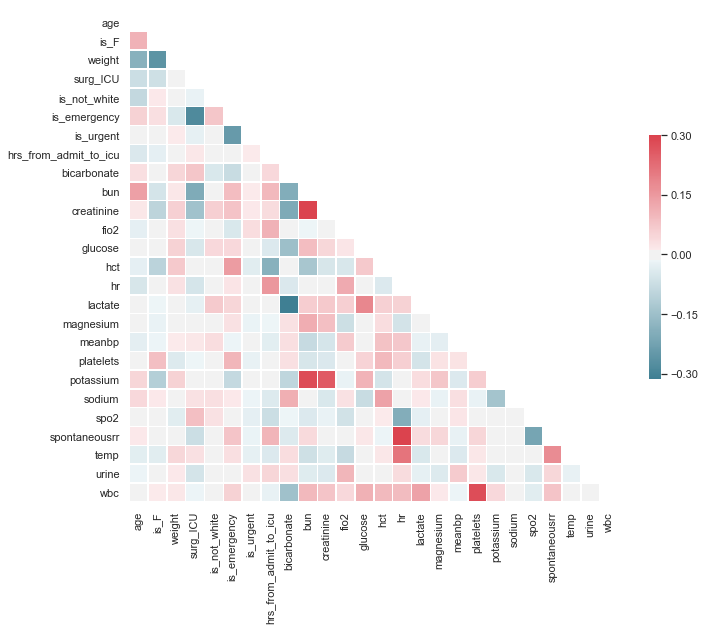

In [40]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [126]:
coverage = (corr.values > 0.1).astype(int)
coverage

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

In [117]:
##1's indicate the patient's feature is in bad condition, 0's means feature values in normal

x_train['age'] = np.where(x_train['age']>=60,1,0)
x_train['weight'] = np.where(x_train['weight']>=75,1,0)
x_train['hrs_from_admit_to_icu'] = np.where(x_train['hrs_from_admit_to_icu']>=1,1,0)
x_train['bicarbonate'] = np.where(x_train['bicarbonate']<=20,1,0)
x_train['bun'] = np.where(np.logical_and(x_train['bun']>=7,x_train['bun']<=20),0,1)
x_train['creatinine'] = np.where(np.logical_and(x_train['creatinine']>=0.5,x_train['creatinine']<=1.2),0,1)
x_train['fio2'] = np.where(x_train['fio2']>=0.5,1,0)
x_train['glucose'] = np.where(x_train['glucose']>=125,1,0)
x_train['hct'] = np.where(np.logical_and(x_train['hct']>=37,x_train['hct']<=52),0,1)
x_train['hr'] = np.where(np.logical_and(x_train['hr']>=70,x_train['hr']<=119),0,1)
x_train['lactate'] = np.where(x_train['lactate']>=2,1,0)
x_train['magnesium'] = np.where(np.logical_and(x_train['magnesium']>=1.5,x_train['magnesium']<=2.5),0,1)
x_train['meanbp'] = np.where(x_train['meanbp']<=65,1,0)
x_train['platelets'] = np.where(np.logical_and(x_train['platelets']>=140,x_train['platelets']<=450),0,1)
x_train['potassium'] = np.where(np.logical_and(x_train['potassium']>=3,x_train['potassium']<=4.9),0,1)
x_train['sodium'] = np.where(np.logical_and(x_train['sodium']>=125,x_train['potassium']<=144),0,1)
x_train['spo2'] = np.where(x_train['spo2']<=95,1,0)
x_train['spontaneousrr'] = np.where(np.logical_and(x_train['spontaneousrr']>=12,x_train['spontaneousrr']<=25),0,1)
x_train['temp'] = np.where(x_train['temp']>=39,1,0)
x_train['urine'] = np.where(x_train['urine']<=100,1,0)
x_train['wbc'] = np.where(np.logical_and(x_train['wbc']>=4.3,x_train['wbc']<=10.8),0,1)


In [55]:
df_for_median = x_train.drop(['ICU_ID','is_F','is_not_white','is_emergency','is_urgent','surg_ICU'],axis=1)
median_dict = {}
for column in df_for_median.columns:
    #median_dict[column] = np.median(df_for_median[column].values)
    print(column,np.sum(df_for_median[column].values))
    #print(column)

age 669
weight 547
hrs_from_admit_to_icu 474
bicarbonate 149
bun 602
creatinine 278
fio2 1000
glucose 604
hct 726
hr 97
lactate 261
magnesium 23
meanbp 81
platelets 195
potassium 148
sodium 18
spo2 109
spontaneousrr 96
temp 8
urine 929
wbc 440


In [51]:
output = pd.concat([x_train,y_train],axis=1)

In [52]:
output.to_csv('synthetic.csv')

In [63]:
# manual_coverage = np.array([[1,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1],
# [0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
# [0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1],
# [1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
# [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
# [0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
# [0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
# [0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
# [1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0],
# [1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
# [1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0],
# [1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
# [1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],
# [1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1],
# [0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0],
# [1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
# [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
# [1,0,1,0,0,1,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1],
# [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1],
# [1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0],
# [1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0],
# [1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0],
# [1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0],
# [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1],
# [1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0],
# [1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1]])

In [118]:
x_train = x_train.drop(['ICU_ID'],axis=1)

Starting DOPS when dropping ('lactate',)
Iter 100 : [3.33477633 0.53073593 0.         3.68398268 0.         0.22597403
 1.66666667 1.77323232 0.         0.         0.         0.
 0.         1.64040404 2.47323232 0.         0.1047619  0.27936508
 0.         0.         1.9        0.38730159 0.41673882 0.41673882
 0.94805195 0.        ]
Iter 200 : [3.33391053 0.         1.25339105 0.68398268 1.84300144 4.11298701
 0.33333333 0.         3.02619048 4.27979798 4.27979798 0.
 1.98730159 0.         0.         1.98730159 0.         0.
 0.59119769 4.27979798 0.         0.         0.         0.
 0.97402597 0.59119769]
Iter 100 : [4.78095238 2.98809524 0.         0.         0.         0.625
 1.35714286 0.         3.44166667 0.         0.         0.
 0.         1.11071429 0.         0.         1.18214286 0.6202381
 0.         0.         0.54285714 2.77857143 1.05       1.05
 0.725      0.        ]
Iter 200 : [3.78095238 0.         0.         5.30357143 0.         0.
 0.39285714 3.70238095 0.       

Iter 200 : [1.08333333 0.         3.87698413 0.         0.09126984 2.11111111
 0.66666667 0.29365079 0.         0.         0.         0.
 0.1984127  0.         0.58531746 0.1984127  1.375      0.99404762
 0.         0.         3.625      0.         2.12896825 2.12896825
 2.72222222 0.        ]
Iter 100 : [0.64761905 0.         6.08452381 0.         5.28809524 2.60119048
 0.         0.         0.         2.63214286 2.63214286 0.
 0.         0.         0.         0.         0.         0.
 0.         2.63214286 0.28571429 0.         0.         0.
 0.         0.        ]
Iter 200 : [1.23809524 0.         5.08452381 0.         5.28809524 2.88214286
 0.         0.         0.         1.63214286 1.63214286 0.
 0.         0.         0.         0.         1.64285714 0.
 0.         1.63214286 0.         0.         0.         0.
 2.12857143 0.        ]
Iter 100 : [1.50541126e+00 1.94805195e+00 0.00000000e+00 6.54145022e+00
 3.09253247e+00 1.37272727e+00 2.70000000e+00 0.00000000e+00
 7.44588745e-0

Iter 200 : [0.63571429 0.         3.8702381  0.         0.         0.91309524
 0.5        0.         2.41230159 5.52619048 5.52619048 0.
 2.67301587 0.         0.         2.67301587 0.         0.
 0.43809524 5.52619048 3.51785714 0.         0.         0.
 1.9265873  0.43809524]
Iter 100 : [0.58571429 4.42857143 0.         0.         0.         0.
 1.         0.         5.19166667 0.         0.         0.
 0.         0.         0.         0.         1.65       0.79761905
 4.86309524 0.         2.         2.125      0.77142857 0.77142857
 3.60714286 4.86309524]
Iter 200 : [1.46428571 0.42857143 0.         6.35952381 0.         0.
 0.         0.         3.38333333 0.24761905 0.24761905 0.
 2.6        0.0547619  0.         2.6        1.3        0.
 0.86309524 0.24761905 1.         0.         0.         0.
 2.98809524 0.86309524]
Iter 100 : [3.42474747e+00 0.00000000e+00 3.63863636e+00 3.99974747e+00
 1.42954545e+00 2.27121212e+00 2.12121212e+00 0.00000000e+00
 0.00000000e+00 1.07777778e+00

Iter 200 : [2.29166667 0.         3.0489899  2.51363636 2.5267316  4.21890332
 0.125      0.         0.         1.05916306 1.05916306 0.
 2.31147186 0.         0.         2.31147186 0.         0.
 0.82272727 1.05916306 1.4040404  0.         0.         0.
 2.11111111 0.82272727]
Iter 100 : [6.72222222e-01 0.00000000e+00 5.86666667e+00 0.00000000e+00
 3.08888889e+00 0.00000000e+00 8.00000000e-01 1.33888889e+00
 2.25000000e+00 2.10000000e+00 2.10000000e+00 4.44089210e-14
 0.00000000e+00 0.00000000e+00 1.65000000e+00 0.00000000e+00
 4.00000000e-01 0.00000000e+00 1.50000000e-01 2.10000000e+00
 2.50000000e+00 0.00000000e+00 1.11666667e+00 1.11666667e+00
 4.10000000e+00 1.50000000e-01]
Iter 200 : [0.00000000e+00 0.00000000e+00 3.86666667e+00 0.00000000e+00
 8.88888889e-02 2.25000000e+00 8.00000000e-01 0.00000000e+00
 2.25000000e+00 1.57777778e+00 1.57777778e+00 8.88178420e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.90000000e+00 1.44444444e-01 0.00000000e+00 1.57777778e

Iter 100 : [2.70779221 0.         0.56691919 0.         0.         2.47366522
 0.         0.         1.57034632 3.93650794 3.93650794 0.
 2.70472583 0.         0.         2.70472583 0.14249639 0.
 2.54906205 3.93650794 0.         0.88654401 2.01749639 2.01749639
 0.4047619  2.54906205]
Iter 200 : [0.41558442 0.         4.56691919 0.         0.         0.23683261
 0.         0.         0.         0.27777778 0.27777778 0.
 0.         0.         0.01334776 0.         0.         0.
 0.54906205 0.27777778 0.02272727 0.         0.01749639 0.01749639
 1.63095238 0.54906205]
Iter 100 : [2.05238095e+00 1.27619048e+00 0.00000000e+00 5.97222222e+00
 0.00000000e+00 8.96031746e-01 5.47619048e-01 0.00000000e+00
 0.00000000e+00 4.66428571e+00 4.66428571e+00 2.22044605e-14
 1.07142857e+00 0.00000000e+00 0.00000000e+00 1.07142857e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.66428571e+00
 7.61904762e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.48888889e+00 0.00000000e+00]
Iter 200 : [1.052

Iter 200 : [2.07294372 0.         4.38701299 0.         1.18896104 0.
 0.42857143 0.         2.85010823 2.94880952 2.94880952 0.
 2.48841991 0.         0.         2.48841991 1.70995671 0.3004329
 1.89393939 2.94880952 1.2        0.         0.         0.
 0.6547619  1.89393939]
Iter 100 : [0.56208791 0.         2.1038628  0.50729271 3.11661672 0.61978022
 1.         0.         0.         0.44114219 0.44114219 0.
 0.         0.         0.         0.         0.91666667 0.
 0.         0.44114219 0.         0.         0.         0.
 0.67857143 0.        ]
Iter 200 : [0.         0.         1.1038628  1.50729271 0.         2.53992674
 0.66666667 1.51351981 0.         2.44114219 2.44114219 0.
 0.         0.         1.84685315 0.         0.58333333 0.97808858
 0.         2.44114219 1.56666667 0.79072594 0.         0.
 0.72527473 0.        ]
Iter 100 : [2.35769231 0.         0.8047619  2.96858974 1.65347985 4.95274725
 0.2        1.65173993 0.         1.63205128 1.63205128 0.
 1.36025641 0.     

Iter 200 : [0.         2.23131868 1.10671551 0.         0.         2.09615385
 0.40384615 0.         6.57527473 3.72155067 3.72155067 0.
 4.5291514  0.         0.         4.5291514  1.53333333 0.
 4.46413309 3.72155067 3.61538462 0.         0.         0.
 1.04761905 4.46413309]
Starting DOPS when dropping ('bicarbonate',)
Iter 100 : [1.9047619  0.         4.68531746 0.         1.33531746 2.44722222
 1.         0.         0.         5.78809524 5.78809524 0.
 3.96785714 1.00396825 0.         3.96785714 0.82619048 0.
 2.95595238 5.78809524 3.91666667 0.         0.         0.
 2.09285714 2.95595238]
Iter 200 : [2.61904762 0.         0.         3.6765873  3.33531746 1.09761905
 0.83333333 1.64444444 0.         0.3047619  0.3047619  0.
 2.93571429 0.50198413 1.13055556 2.93571429 1.43571429 0.
 0.91190476 0.3047619  1.95238095 0.         0.         0.
 0.         0.91190476]
Iter 100 : [1.70509607 3.69615706 0.         0.         0.         0.84895572
 0.         0.         2.34486216 2.3429

Iter 200 : [4.6728355  4.4724026  0.         4.9728355  0.         2.24642857
 0.         0.         0.         0.23073593 0.23073593 0.
 0.         2.49036797 0.         0.         0.33766234 0.
 0.         0.23073593 2.93333333 0.         0.         0.
 0.65367965 0.        ]
Iter 100 : [8.52380952e-01 0.00000000e+00 0.00000000e+00 6.20634921e+00
 0.00000000e+00 9.12698413e-01 1.66666667e-01 5.22341270e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.22044605e-14
 1.27380952e+00 0.00000000e+00 3.68174603e+00 1.27380952e+00
 1.57777778e+00 4.65079365e-01 0.00000000e+00 0.00000000e+00
 4.04444444e+00 1.85317460e-01 0.00000000e+00 0.00000000e+00
 2.51428571e+00 0.00000000e+00]
Iter 200 : [1.13928571e+00 0.00000000e+00 2.90396825e+00 2.06349206e-01
 0.00000000e+00 0.00000000e+00 8.33333333e-01 0.00000000e+00
 2.76190476e+00 2.57936508e+00 2.57936508e+00 4.44089210e-14
 1.36904762e-01 0.00000000e+00 0.00000000e+00 1.36904762e-01
 1.11111111e-01 0.00000000e+00 8.07142857e-01 2.57936508e

Iter 100 : [7.32384135e+00 0.00000000e+00 0.00000000e+00 4.77134581e+00
 0.00000000e+00 0.00000000e+00 1.35606061e+00 8.00118835e-01
 0.00000000e+00 4.10160428e-01 4.10160428e-01 6.66133815e-14
 0.00000000e+00 2.60650624e-01 7.43612597e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10160428e-01
 0.00000000e+00 6.99970291e-01 0.00000000e+00 0.00000000e+00
 9.71746881e-01 0.00000000e+00]
Iter 200 : [2.66889483e-01 1.09863339e+00 0.00000000e+00 5.77134581e+00
 0.00000000e+00 1.21553773e+00 8.71212121e-01 1.80011884e+00
 2.13756684e+00 0.00000000e+00 0.00000000e+00 1.33226763e-13
 0.00000000e+00 2.26065062e+00 1.07436126e+00 0.00000000e+00
 7.46212121e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.70142602e-01 0.00000000e+00]
Iter 100 : [5.22771673 4.18455433 0.         5.57820513 0.         0.
 0.75       3.01391941 0.         3.1034188  3.1034188  0.
 1.78803419 0.         2.51391941 1.78803419 1.028021

Iter 100 : [0.         3.95952381 0.         0.         0.         6.17142857
 0.46785714 0.         1.88809524 0.         0.         0.
 0.         0.9797619  0.         0.         1.31666667 0.90952381
 8.31666667 0.         2.66666667 1.38571429 0.         0.
 1.83333333 8.31666667]
Iter 200 : [0.         3.95952381 0.         3.53214286 0.         2.05714286
 0.46785714 0.         0.88809524 1.22619048 1.22619048 0.
 2.93809524 1.9797619  0.         2.93809524 2.60833333 0.
 2.31666667 1.22619048 1.66666667 2.38571429 0.         0.
 1.16666667 2.31666667]
Starting DOPS when dropping ('lactate', 'sodium')
Iter 100 : [2.52254902 2.3179972  0.         0.         2.7609944  4.68277311
 0.         0.         3.22556022 0.55672269 0.55672269 0.
 0.9262605  0.         0.         0.9262605  1.80952381 0.60119048
 4.58634454 0.55672269 2.16666667 0.7        1.16953782 1.16953782
 1.17142857 4.58634454]
Iter 200 : [2.13739496 2.3179972  0.         0.         0.         4.67857143
 0.        

Iter 200 : [0.71666667 4.92619048 0.         5.48690476 0.         1.29047619
 0.80357143 0.         1.57142857 1.4        1.4        0.
 0.         1.63690476 0.         0.         1.33333333 0.
 0.         1.4        2.         0.         0.         0.
 1.8        0.        ]
Iter 100 : [2.85714286e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.64761905e+00 3.33333333e-01 0.00000000e+00
 0.00000000e+00 2.04761905e+00 2.04761905e+00 2.22044605e-14
 1.00634921e+00 0.00000000e+00 0.00000000e+00 1.00634921e+00
 3.61111111e-01 0.00000000e+00 4.12460317e+00 2.04761905e+00
 0.00000000e+00 1.33968254e+00 0.00000000e+00 0.00000000e+00
 2.71428571e+00 4.12460317e+00]
Iter 200 : [8.80952381e-01 0.00000000e+00 7.42857143e-01 0.00000000e+00
 3.21984127e+00 1.64761905e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.04761905e+00 1.04761905e+00 4.44089210e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.24603175e-01 1.04761905e

Iter 200 : [3.69047619 0.         0.         3.9452381  0.         3.12857143
 0.36666667 0.36904762 0.         1.24285714 1.24285714 0.
 0.         0.3047619  0.         0.         0.         0.1452381
 1.01428571 1.24285714 0.         0.         0.         0.
 1.66666667 1.01428571]
Iter 100 : [2.25555556e+00 0.00000000e+00 5.53809524e+00 0.00000000e+00
 0.00000000e+00 3.84166667e+00 2.03571429e+00 1.97738095e+00
 2.75476190e+00 2.35714286e-01 2.35714286e-01 4.44089210e-14
 3.44444444e-01 0.00000000e+00 2.39404762e+00 3.44444444e-01
 2.41666667e+00 0.00000000e+00 1.48253968e+00 2.35714286e-01
 4.19047619e+00 0.00000000e+00 1.47976190e+00 1.47976190e+00
 4.66111111e+00 1.48253968e+00]
Iter 200 : [8.13888889e-01 3.27341270e+00 0.00000000e+00 6.87420635e+00
 0.00000000e+00 2.04722222e+00 1.46428571e+00 0.00000000e+00
 5.84920635e-01 2.35714286e-01 2.35714286e-01 8.88178420e-14
 2.58611111e+00 1.96111111e+00 0.00000000e+00 2.58611111e+00
 3.20833333e+00 0.00000000e+00 0.00000000e+00 2.35

Iter 100 : [1.0525641  6.12005495 0.         0.         0.         4.76785714
 0.5        0.         4.95815018 0.         0.         0.
 2.13782051 0.92188645 0.         2.13782051 2.10714286 0.57216117
 5.36611722 0.         1.41346154 0.33003663 1.40888278 1.40888278
 1.75       5.36611722]
Iter 200 : [3.58269231 0.         0.48177656 5.0779304  0.         2.62087912
 0.875      3.30228938 0.         0.65412088 0.65412088 0.
 0.         0.         2.59395604 0.         0.03571429 0.
 0.         0.65412088 0.40384615 0.         0.         0.
 2.8452381  0.        ]
Iter 100 : [4.11111111e-01 0.00000000e+00 5.70555556e+00 0.00000000e+00
 1.00000000e+00 5.52500000e+00 1.80000000e+00 0.00000000e+00
 3.03611111e+00 6.38888889e-01 6.38888889e-01 2.22044605e-14
 4.46388889e+00 0.00000000e+00 0.00000000e+00 4.46388889e+00
 4.00000000e+00 2.87222222e+00 4.99166667e+00 6.38888889e-01
 2.00000000e+00 2.08333333e+00 1.28055556e+00 1.28055556e+00
 8.88888889e-01 4.99166667e+00]
Iter 200 : [8.222

Iter 100 : [6.3960706  0.6483461  0.         3.12987845 0.         0.
 0.14285714 1.77226385 0.25433733 0.65784216 0.65784216 0.
 2.6763875  2.623557   1.89726385 2.6763875  0.90576923 0.
 0.         0.65784216 0.         1.43308081 0.         0.
 0.63636364 0.        ]
Iter 200 : [1.10962371 1.6483461  0.         3.25975691 0.         0.
 0.28571429 1.77226385 1.25433733 1.31568432 1.31568432 0.
 0.6763875  0.         1.89726385 0.6763875  1.63525641 0.
 0.         1.31568432 1.45501166 0.43308081 0.         0.
 0.         0.        ]
Iter 100 : [0.         0.51918768 0.         0.         2.45098039 0.94747899
 1.33333333 0.         3.0047619  0.         0.         0.
 0.73851541 0.         0.         0.73851541 0.58333333 0.
 0.         0.         1.83361345 0.         1.02170868 1.02170868
 0.35616246 0.        ]
Iter 200 : [3.34614846 0.         0.         5.06848739 0.         3.7789916
 0.43333333 0.         0.         0.44264706 0.44264706 0.
 0.         0.         0.         0

Iter 200 : [4.29456377e+00 2.50451493e+00 0.00000000e+00 4.38781219e+00
 0.00000000e+00 4.23321123e+00 1.75000000e+00 5.43736541e+00
 0.00000000e+00 4.18632479e+00 4.18632479e+00 4.44089210e-14
 1.97683983e+00 0.00000000e+00 4.76438561e+00 1.97683983e+00
 0.00000000e+00 0.00000000e+00 1.55770063e+00 4.18632479e+00
 0.00000000e+00 7.14296814e-01 2.95163170e-01 2.95163170e-01
 0.00000000e+00 1.55770063e+00]
Iter 100 : [1.16785714 2.05634921 0.         1.03888889 0.         4.46984127
 0.66666667 0.         4.43730159 2.71825397 2.71825397 0.
 0.         0.         0.         0.         3.16666667 0.
 0.         2.71825397 2.93333333 0.06309524 0.         0.
 0.77777778 0.        ]
Iter 200 : [0.61309524 0.         0.         2.03888889 3.39920635 1.6984127
 0.88888889 0.         1.43730159 5.71825397 5.71825397 0.
 0.         0.         0.         0.         1.05555556 0.
 0.         5.71825397 0.13333333 0.         0.         0.
 1.06349206 0.        ]
Iter 100 : [2.02777778 0.         

Iter 200 : [1.54442641e+00 2.27720058e+00 0.00000000e+00 2.27312410e+00
 0.00000000e+00 4.47128427e+00 0.00000000e+00 0.00000000e+00
 1.35465368e+00 2.63239538e+00 2.63239538e+00 4.44089210e-14
 2.79814214e+00 3.54329004e-01 0.00000000e+00 2.79814214e+00
 2.39920635e+00 0.00000000e+00 4.18778860e+00 2.63239538e+00
 2.20000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.86111111e-01 4.18778860e+00]
Iter 100 : [2.76060606 0.38712121 0.         2.10768398 3.38398268 1.97402597
 1.07954545 0.         0.         1.61580087 1.61580087 0.
 0.86255411 0.44080087 0.         0.86255411 0.         0.
 1.26082251 1.61580087 0.81666667 0.         0.         0.
 0.         1.26082251]
Iter 200 : [2.88787879 6.38712121 0.         5.10768398 0.         1.78441558
 1.73409091 0.         2.80768398 0.         0.         0.
 0.         2.44080087 0.19945887 0.         2.93506494 0.49491342
 0.         0.         1.23333333 0.         0.         0.
 0.67142857 0.        ]
Iter 100 : [0.         4.

Iter 100 : [0.45079365 0.         6.33809524 0.         1.03690476 1.28809524
 0.75       0.         0.         3.70555556 3.70555556 0.
 0.         0.         0.         0.         0.         0.
 0.         3.70555556 0.67857143 0.         0.         0.
 0.6031746  0.        ]
Iter 200 : [0.         5.60515873 0.         0.         0.         1.57619048
 0.25       0.         3.09642857 0.41111111 0.41111111 0.
 1.39325397 1.17103175 0.         1.39325397 0.46944444 0.
 0.         0.41111111 0.96785714 0.         0.         0.
 3.20634921 0.        ]
Iter 100 : [1.76468254 4.60753968 0.         0.         0.         2.48809524
 1.85       0.         3.15436508 1.34285714 1.34285714 0.
 0.         0.         0.         0.         1.5        0.24603175
 2.81388889 1.34285714 2.85714286 0.74603175 0.         0.
 1.24404762 2.81388889]
Iter 200 : [2.25277778 0.         1.53253968 1.55515873 0.12936508 0.58571429
 1.625      0.         0.         1.78095238 1.78095238 0.
 0.16984127 0.    

Iter 100 : [3.57142857 0.         0.97420635 0.         0.         3.71031746
 0.         0.         1.23611111 0.         0.         0.
 0.50396825 0.         0.         0.50396825 2.48015873 0.
 0.         0.         1.5        0.         2.4047619  2.4047619
 0.70436508 0.        ]
Iter 200 : [4.07142857 5.30555556 0.         6.67460317 0.         0.26190476
 4.         0.         0.47222222 2.20436508 2.20436508 0.
 0.50396825 0.26785714 0.         0.50396825 0.96031746 0.
 0.         2.20436508 1.         0.         0.         0.
 1.52579365 0.        ]
Iter 100 : [6.20979021e-01 0.00000000e+00 6.03310023e+00 5.15174825e+00
 1.77966200e+00 3.20454545e+00 0.00000000e+00 2.75244755e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.22044605e-14
 0.00000000e+00 0.00000000e+00 3.21078089e+00 0.00000000e+00
 3.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.02121212e+00 1.02121212e+00
 2.66666667e+00 0.00000000e+00]
Iter 200 : [3.40524476e+00

Iter 200 : [3.09437229e+00 0.00000000e+00 2.34426407e+00 3.30299423e+00
 1.96046176e+00 6.14105339e+00 1.16666667e+00 2.64577922e+00
 0.00000000e+00 1.05829726e+00 1.05829726e+00 4.44089210e-14
 0.00000000e+00 6.56313131e-01 2.90335498e+00 0.00000000e+00
 2.25000000e+00 0.00000000e+00 9.81457431e-01 1.05829726e+00
 0.00000000e+00 6.07575758e-01 0.00000000e+00 0.00000000e+00
 2.74242424e+00 9.81457431e-01]
Iter 100 : [3.36825397 0.         1.50634921 0.         0.         0.94603175
 0.         0.         0.         1.80634921 1.80634921 0.
 0.86626984 0.         0.         0.86626984 1.11111111 0.
 0.         1.80634921 2.39285714 0.21269841 0.27579365 0.27579365
 2.33333333 0.        ]
Iter 200 : [2.36825397 0.         0.         0.         4.42936508 3.94603175
 0.         0.         0.         4.9031746  4.9031746  0.
 0.86626984 0.         0.         0.86626984 0.00793651 0.
 0.         4.9031746  2.46428571 0.         0.         0.
 2.66666667 0.        ]
Iter 100 : [4.52222222 0.

Iter 200 : [1.39340659 1.8456044  0.         0.         2.67692308 9.98663004
 0.         0.         3.87435897 0.35274725 0.35274725 0.
 3.68406593 0.         0.         3.68406593 0.80238095 0.
 5.91849817 0.35274725 4.66666667 0.18791209 0.         0.
 0.         5.91849817]
Iter 100 : [4.09722222 1.2484127  0.         7.23849206 0.         4.04444444
 0.         4.52698413 0.         0.         0.         0.
 1.38650794 0.35714286 3.86984127 1.38650794 0.         0.
 0.         0.         0.47619048 0.41507937 0.         0.
 1.15555556 0.        ]
Iter 200 : [6.01944444 3.12420635 0.         9.23849206 0.         2.52222222
 0.         4.52698413 0.         3.05       3.05       0.
 0.         0.35714286 4.86984127 0.         0.         0.
 0.         3.05       2.07142857 0.41507937 1.0202381  1.0202381
 1.04444444 0.        ]
Iter 100 : [1.56349206 0.         6.43849206 0.         0.         4.88690476
 0.         0.73809524 0.46428571 0.         0.         0.
 0.         0.     

Iter 100 : [3.70238095 0.         3.0047619  0.         2.14761905 0.00952381
 1.2        0.         0.         2.62380952 2.62380952 0.
 0.         0.         0.         0.         0.65       0.
 0.63333333 2.62380952 0.66666667 0.         0.         0.
 1.7        0.63333333]
Iter 200 : [3.46428571 0.7547619  0.         4.57619048 2.14761905 2.02857143
 0.3        3.63095238 0.         1.4952381  1.4952381  0.
 0.         0.         3.79761905 0.         2.06666667 1.2952381
 0.         1.4952381  4.8        2.18571429 0.         0.
 2.03333333 0.        ]
Iter 100 : [0.48225108 0.         0.56922799 0.         0.         3.597114
 1.         0.         2.87272727 0.68430736 0.68430736 0.
 0.         0.         0.         0.         1.53809524 0.
 3.79098124 0.68430736 1.59285714 0.54051227 2.38730159 2.38730159
 0.         3.79098124]
Iter 200 : [0.74112554 0.         0.         0.         0.         0.79134199
 1.2        0.         4.87272727 0.78953824 0.78953824 0.
 0.         0

Iter 100 : [0.         0.         1.88988095 0.         4.96309524 6.27440476
 0.2125     0.         2.21071429 0.         0.         0.
 0.35833333 0.         0.         0.35833333 0.         0.78690476
 0.         0.         2.89285714 0.93690476 2.93928571 2.93928571
 0.625      0.        ]
Iter 200 : [0.21309524 0.         7.88988095 0.         2.96309524 2.54880952
 1.625      1.83035714 1.21071429 2.34642857 2.34642857 0.
 0.         0.21369048 2.05952381 0.         0.55       1.78690476
 0.         2.34642857 0.96428571 0.         1.93928571 1.93928571
 0.         0.        ]
Iter 100 : [0.90659341 0.63949939 0.         3.31221001 1.88315018 0.
 0.14358974 3.4979243  0.         4.85250305 4.85250305 0.
 0.33076923 0.43821734 3.7479243  0.33076923 1.56666667 0.
 0.         4.85250305 0.         0.         0.56807082 0.56807082
 1.25       0.        ]
Iter 200 : [1.85989011 2.63949939 0.         6.31221001 0.88315018 1.81025641
 0.43076923 2.4979243  0.         7.85250305 7.852503

Iter 100 : [1.64004329 0.         0.         3.61832612 0.64704185 0.92049062
 1.11111111 0.         0.         3.2479798  3.2479798  0.
 0.10634921 0.         0.         0.10634921 0.40692641 0.
 0.         3.2479798  2.64848485 0.         0.         0.
 2.6030303  0.        ]
Iter 200 : [0.84025974 0.         6.04906205 0.         0.94112554 1.44036797
 0.         4.17712843 0.         0.         0.         0.
 0.         0.         4.77712843 0.         1.0021645  0.25400433
 0.         0.         3.64848485 0.         2.36078644 2.36078644
 0.6030303  0.        ]
Iter 100 : [1.67777778 0.         7.24960317 0.         2.83492063 1.34285714
 0.         0.         2.76150794 0.52301587 0.52301587 0.
 0.         0.         0.         0.         1.27857143 0.54126984
 0.85       0.52301587 3.16666667 0.71349206 1.57301587 1.57301587
 1.66666667 0.85      ]
Iter 200 : [2.69444444 0.         5.24960317 0.         0.         2.02857143
 0.         0.         0.         1.28452381 1.284523

Iter 200 : [3.175      0.         2.13939394 0.         3.77272727 0.34545455
 0.3        2.4280303  1.81439394 0.11969697 0.11969697 0.
 0.         0.         2.59469697 0.         0.2        1.46515152
 0.         0.11969697 3.225      2.08939394 2.23939394 2.23939394
 2.13333333 0.        ]
Iter 100 : [1.03846154 1.41391941 0.         8.03992674 0.         0.6959707
 0.48717949 0.         2.77051282 1.15274725 1.15274725 0.
 0.         0.         0.         0.         0.08388278 0.
 1.30613553 1.15274725 2.77142857 0.         0.         0.
 2.56547619 1.30613553]
Iter 200 : [1.53846154 2.41391941 0.         7.03992674 0.         0.
 0.48717949 0.         2.77051282 1.15274725 1.15274725 0.
 0.         0.44212454 0.         0.         2.08388278 0.
 0.         1.15274725 0.54285714 0.         0.         0.
 0.7797619  0.        ]
Starting DOPS when dropping ('hct', 'creatinine')
Iter 100 : [1.9032967  2.41221001 0.         6.92570208 0.         0.
 0.24285714 0.         4.71746032 0.

Iter 200 : [0.2982684  0.31818182 0.         0.         0.         2.54253247
 0.78571429 0.         5.94058442 0.77445887 0.77445887 0.
 1.24556277 0.         0.         1.24556277 0.58452381 0.
 6.84545455 0.77445887 1.04166667 0.61515152 1.40963203 1.40963203
 0.54761905 6.84545455]
Iter 100 : [2.58434066 0.         6.68968254 0.         3.42899878 2.07847985
 0.         0.         0.         3.6514652  3.6514652  0.
 0.797558   0.         0.         0.797558   1.02857143 0.
 0.         3.6514652  2.26153846 0.06648352 1.08989621 1.08989621
 0.28351648 0.        ]
Iter 200 : [0.71688034 0.         4.68968254 0.74181929 1.42899878 3.07847985
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         2.23956044 0.         0.08989621 0.08989621
 1.6043956  0.        ]
Iter 100 : [0.34993895 2.67240537 0.         0.         0.         0.
 2.4        0.24346764 2.41630037 0.         0.         0.
 0.       

Iter 100 : [4.01757964 3.74420857 0.         8.48973526 0.         1.41678322
 0.         5.6033966  0.         6.44598735 6.44598735 0.
 0.37038517 0.41775447 5.7283966  0.37038517 1.90430403 0.
 1.07061827 6.44598735 1.5        1.34883172 0.27308802 0.27308802
 1.83787879 1.07061827]
Iter 200 : [1.11726884 3.74420857 0.         6.48973526 0.         0.
 0.         2.6033966  2.38038351 2.22299367 2.22299367 0.
 0.         0.         1.7283966  0.         0.90430403 0.
 0.         2.22299367 3.25       0.34883172 0.27308802 0.27308802
 0.53156566 0.        ]
Iter 100 : [3.5955564  2.22031449 0.         2.81993888 0.         5.44003056
 0.14285714 0.         0.16203209 3.6030685  3.6030685  0.
 2.00728291 2.22423606 0.         2.00728291 1.06060606 0.
 0.         3.6030685  3.79144385 0.         0.         0.
 3.49554367 0.        ]
Iter 200 : [5.44598294 4.22031449 0.         2.81993888 0.         3.74000509
 0.14285714 2.58006748 0.         0.         0.         0.
 0.03641457 0.    

Iter 100 : [1.68766789 0.         6.14050672 0.         4.12924298 4.10512821
 0.33333333 0.         0.         1.36398046 1.36398046 0.
 0.74279609 0.         0.         0.74279609 0.53333333 0.
 0.         1.36398046 2.6        0.         0.         0.
 1.39047619 0.        ]
Iter 200 : [4.2267094  0.         6.14050672 0.93659951 2.12924298 0.20940171
 1.33333333 1.2793956  0.         0.09099512 0.09099512 0.
 0.74279609 0.         1.55717338 0.74279609 0.         0.
 0.77893773 0.09099512 0.         0.         0.         0.
 0.78095238 0.77893773]
Iter 100 : [4.49646465e+00 2.11565657e+00 0.00000000e+00 4.30101010e+00
 0.00000000e+00 4.82575758e+00 2.91666667e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.66133815e-14
 2.21060606e+00 0.00000000e+00 0.00000000e+00 2.21060606e+00
 9.33333333e-01 0.00000000e+00 2.68409091e+00 0.00000000e+00
 0.00000000e+00 3.31818182e-01 0.00000000e+00 0.00000000e+00
 7.00000000e-01 2.68409091e+00]
Iter 200 : [3.10101010e-01 1.1156

Iter 200 : [3.51448551 0.         2.07994783 0.         0.         3.96216284
 0.33333333 0.         1.52268565 0.69463869 0.69463869 0.
 0.         0.         0.         0.         3.66666667 0.
 0.         0.69463869 2.10576923 0.         0.         0.
 1.84926185 0.        ]
Iter 100 : [5.68484848 0.         4.20530303 0.         2.89372294 2.14545455
 0.4        0.12049062 0.         0.93055556 0.93055556 0.
 0.         0.         0.60660173 0.         0.         0.
 0.         0.93055556 2.975      0.62738095 0.         0.
 0.01010101 0.        ]
Iter 200 : [1.02676768 4.00577201 0.         0.         0.         2.86060606
 1.85       0.         6.22435065 0.         0.         0.
 0.         1.1        0.         0.         1.975      0.51078644
 2.71926407 0.         2.525      0.62738095 0.         0.
 0.42929293 2.71926407]
Iter 100 : [1.62020202e+00 0.00000000e+00 4.69444444e+00 3.05050505e-01
 1.88232323e+00 0.00000000e+00 0.00000000e+00 5.94949495e-01
 0.00000000e+00 0.0000

KeyboardInterrupt: 

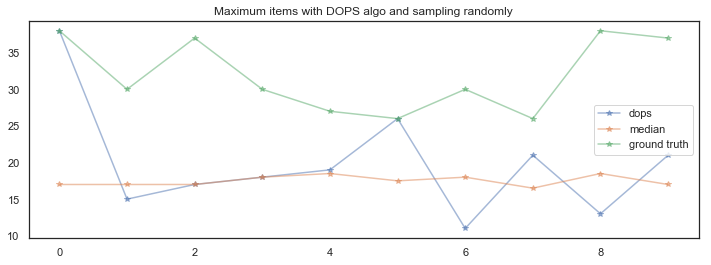

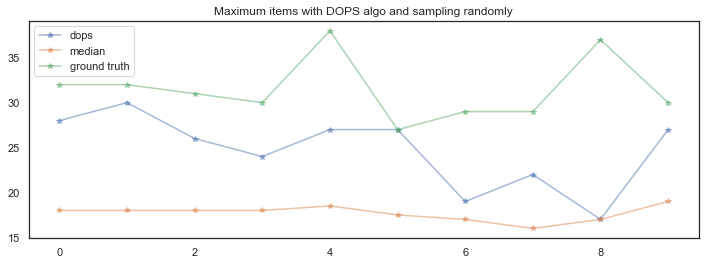

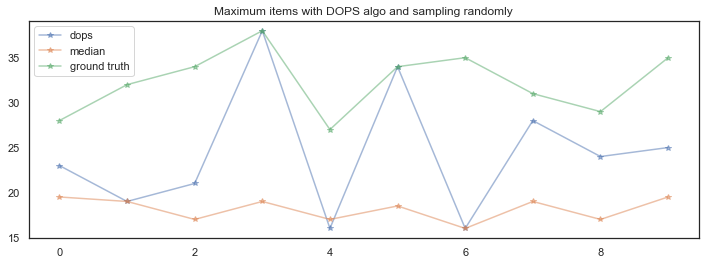

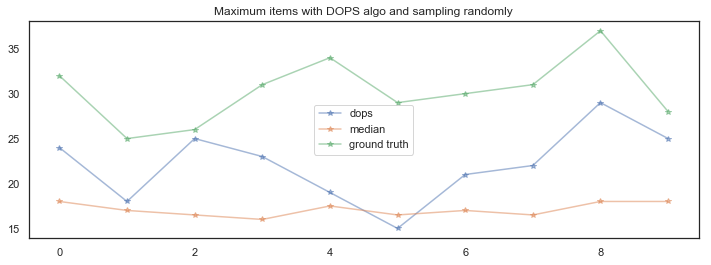

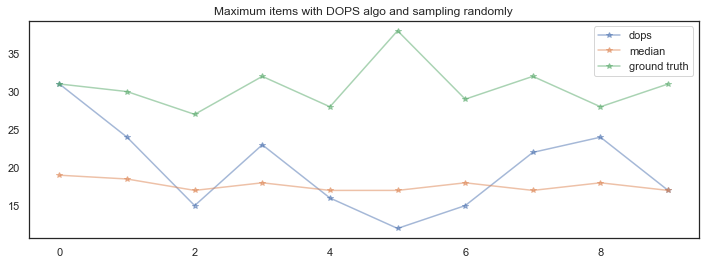

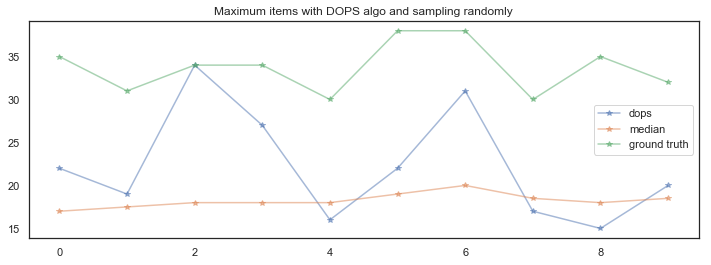

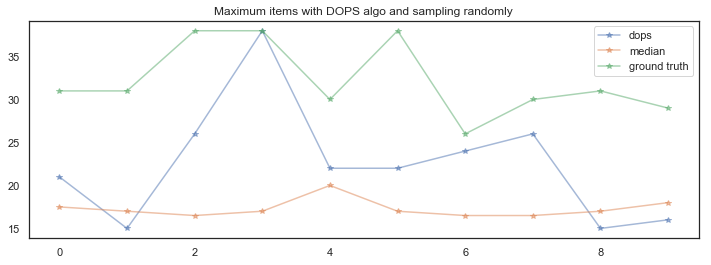

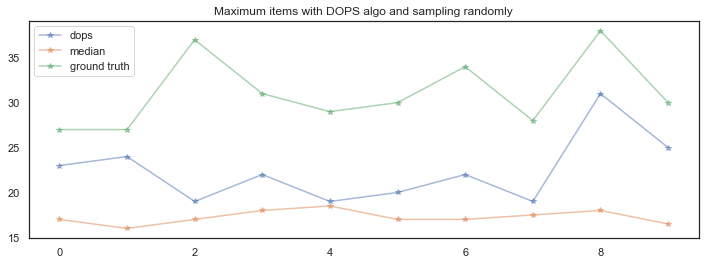

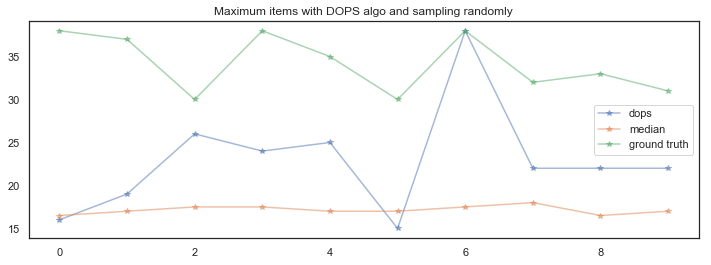

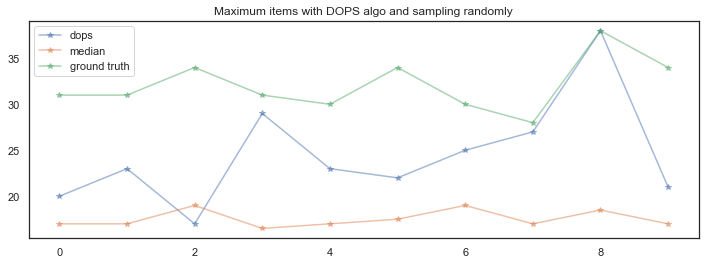

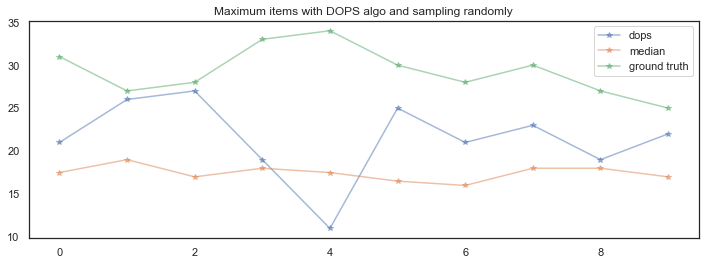

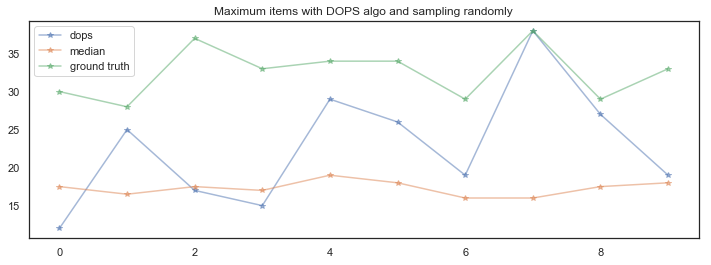

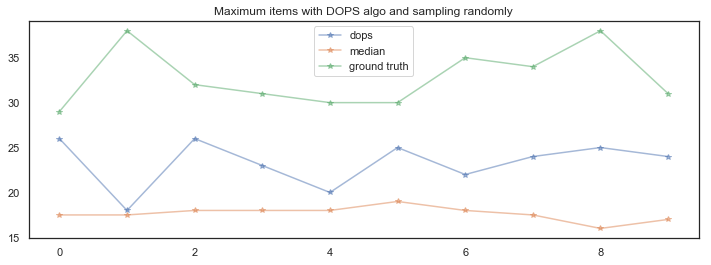

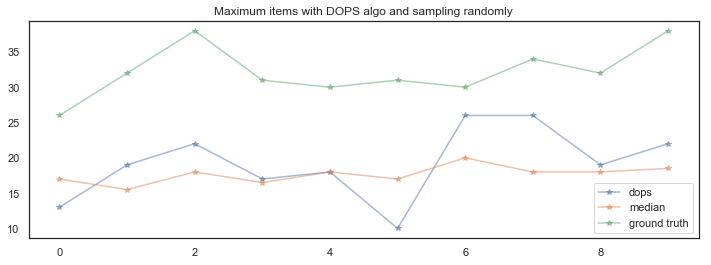

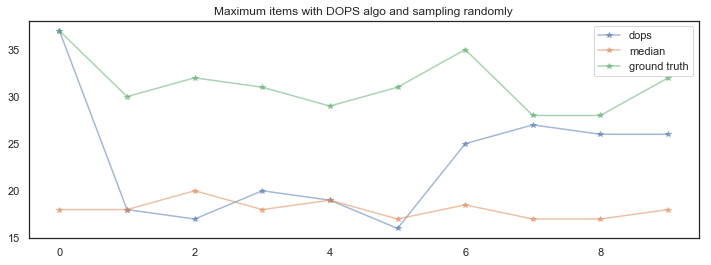

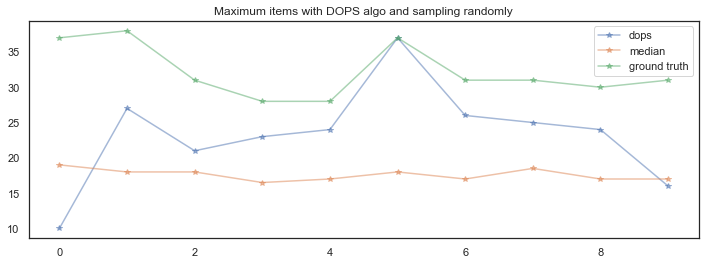

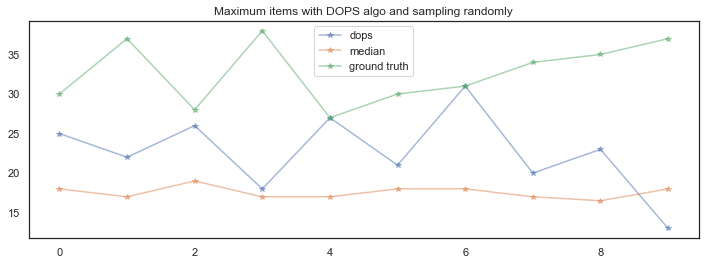

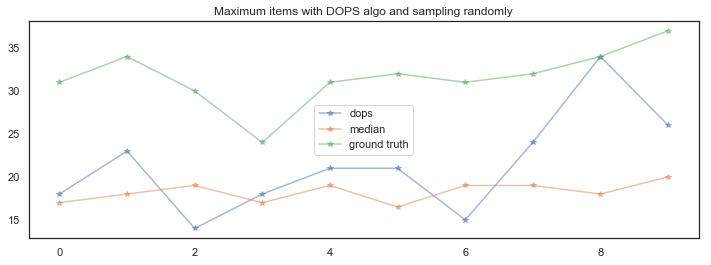

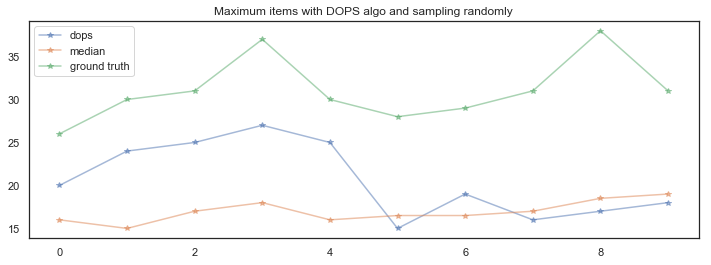

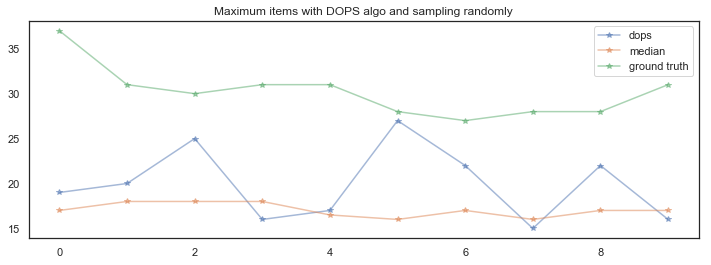

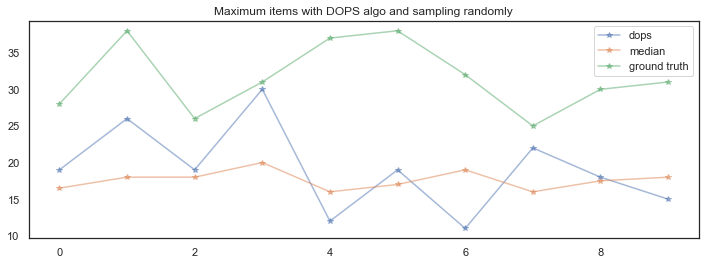

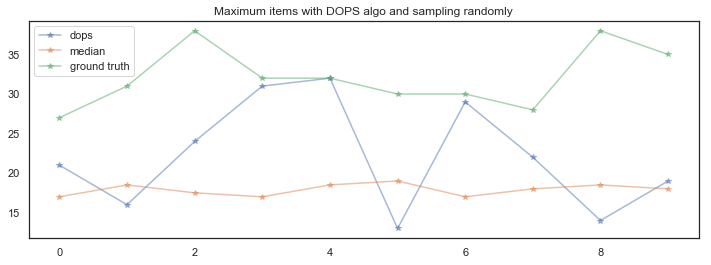

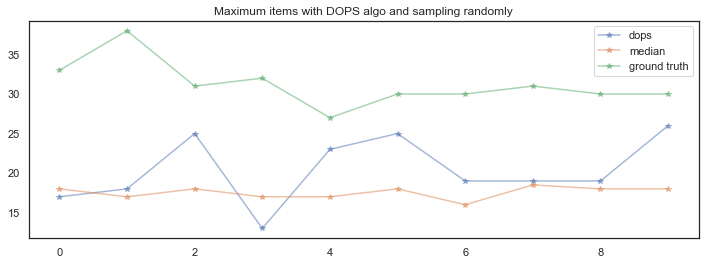

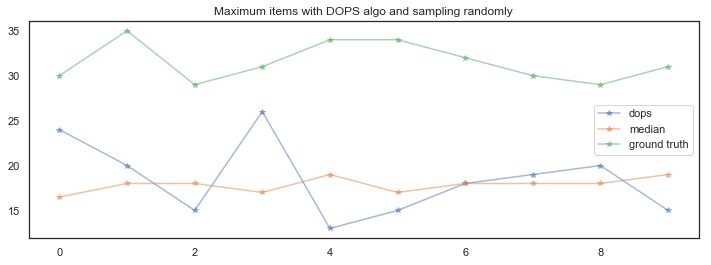

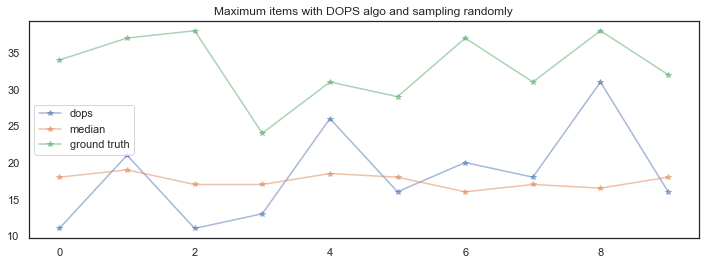

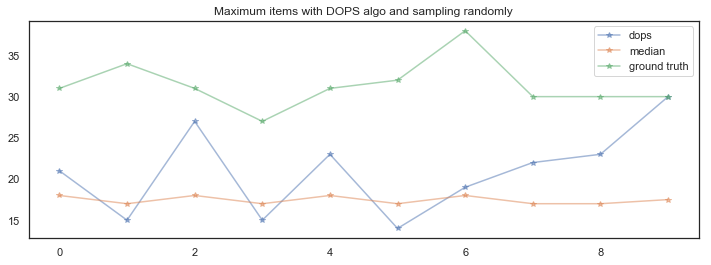

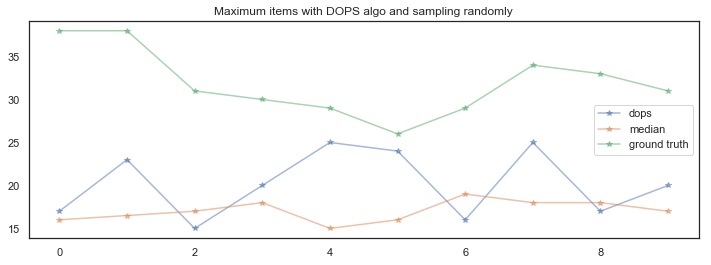

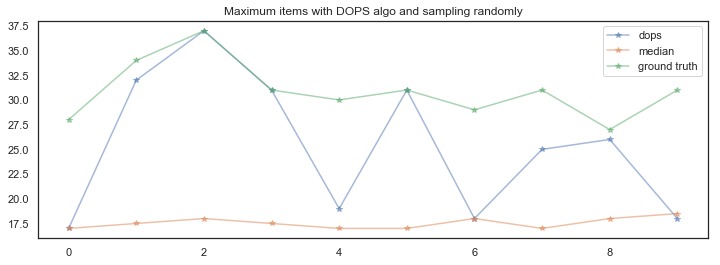

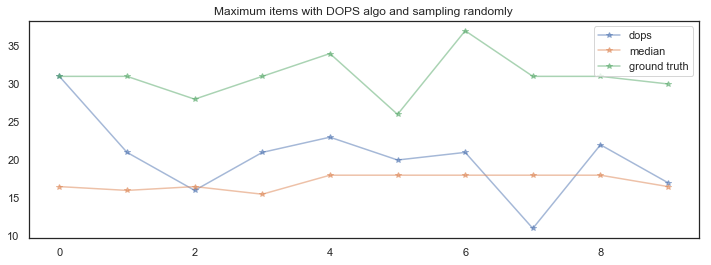

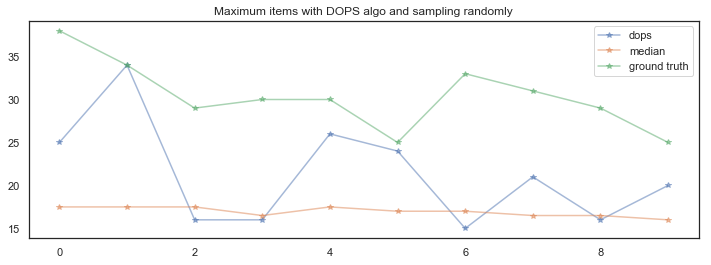

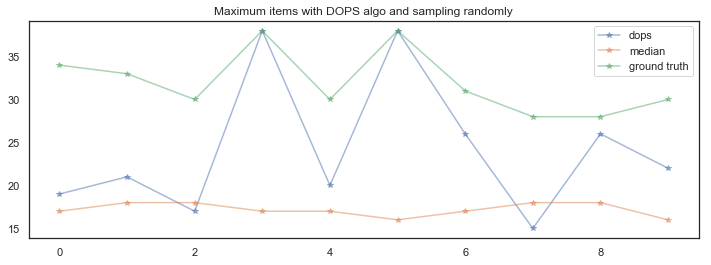

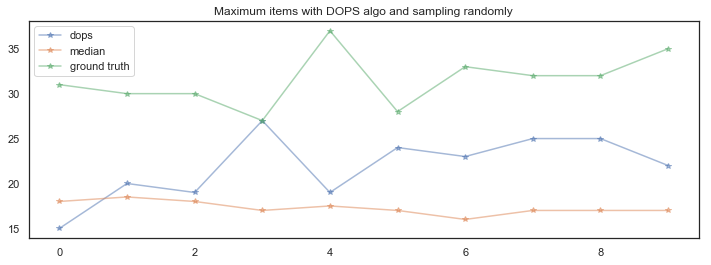

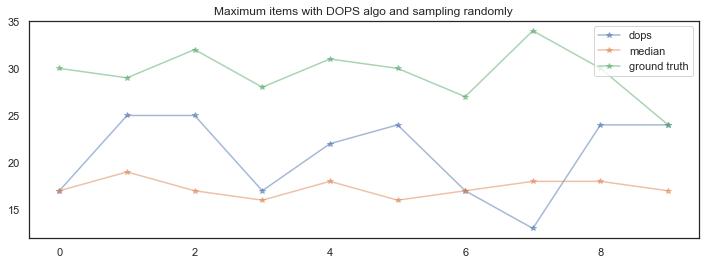

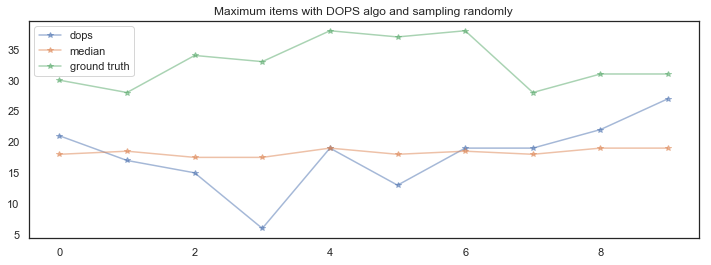

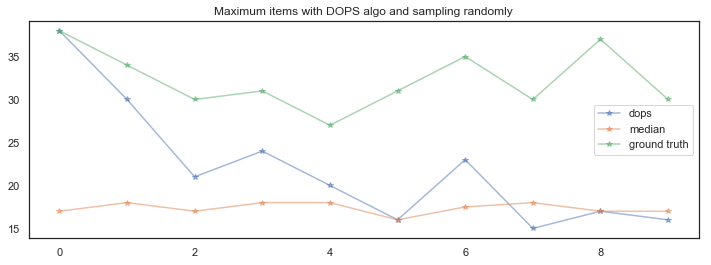

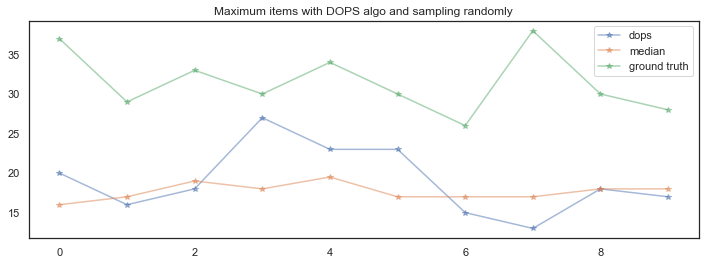

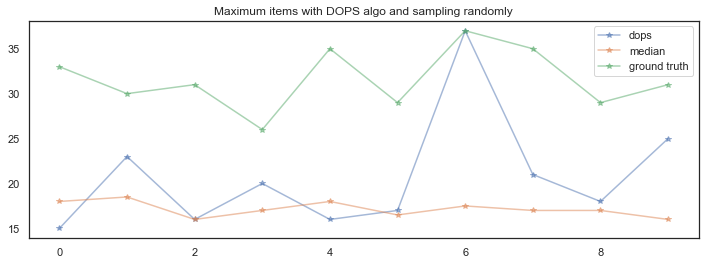

In [124]:
from itertools import combinations
harder_measure = ['lactate','platelets','bun','hct','creatinine','magnesium','potassium','bicarbonate']


for item in combinations(harder_measure,2):
    ##Randomly select 1000 items from the master
    x,y = np.random.choice(x_train,size=1000,replace=False), np.random.choice(y_train,size=1000,replace=False)
    print("Starting DOPS when dropping " + str(item))
    measure = list(item)
    mdt = x.copy()
    mdt[measure] = 0
    x_train_dops = mdt.values
    y_train_dops = y['saps'].values

    preds = []
    truths = []

    for i in range(10):
        X_train, X_test,Y_train,Y_test = train_test_split(x_train_dops,y_train_dops,test_size=0.05)
        test_len = len(Y_test)
        res, pred_theta, max_item_index = dops(X_train, Y_train, X_test, coverage, test_len, 0.8, np.zeros(26), eta=1, iters=200,print_every=100)

        preds.append(res)
        truths.append(Y_test)

    pred = []
    real = []
    rand = []
    for i in range(10):
        pred.append(truths[i][np.argmax(preds[i])])
        real.append(max(truths[i]))
        rand.append(np.median(truths[i]))

    plt.figure(figsize=(12,4))
    plt.plot(np.arange(0,10), pred, '*-', alpha=0.5, label='dops')
    plt.plot(np.arange(0,10), rand, '*-', alpha=0.5, label='median')
    plt.plot(np.arange(0,10), real, '*-', alpha=0.5, label='ground truth')
    plt.legend()
    plt.title('Maximum items with DOPS algo and sampling randomly after dropping ' + str(measure))
    plt.savefig("results after dropping " + str(measure))

In [53]:
x_train_dops = x_train.drop(['ICU_ID'],axis=1).values
y_train_dops = y_train['saps'].values + y_train['sofa'].values + y_train['oasis'].values

In [54]:
X_train, X_test,y_train,y_test = train_test_split(x_train_dops,y_train_dops,test_size=0.2)

In [57]:
preds = []
truths = []
random = []
pred_thetas = []

for i in range(10):
    X_train, X_test,y_train,y_test = train_test_split(x_train_dops,y_train_dops,test_size=0.05)
    test_len = len(y_test)
    res, pred_theta, max_item_index = dops(X_train, y_train, X_test, coverage, test_len, 0.8, np.zeros(26), eta=1, iters=200,print_every=100)
    
    preds.append(res)
    truths.append(y_test)
#     preds.append(y_test[np.argmax(res)])
#     truth.append(np.max(y_test))
#     random.append(np.median(y_test))
#     pred_thetas.append(pred_theta)



Iter 100 : [1.63150183 0.         6.28118132 0.         4.90572344 4.77838828
 0.49038462 0.         0.         4.70728022 4.70728022 0.
 0.         0.         0.         0.         1.66153846 0.
 2.55064103 4.70728022 1.54102564 0.         0.         0.
 1.0625     2.55064103]
Iter 200 : [2.20393773 0.         4.28118132 0.         0.         2.45054945
 1.01923077 0.         0.03264652 4.90242674 4.90242674 0.
 1.99139194 0.         0.         1.99139194 0.32307692 0.
 4.55064103 4.90242674 1.75897436 0.         0.         0.
 0.         4.55064103]
Iter 100 : [1.64126984 0.         3.5468254  0.         0.         3.89880952
 1.75       0.         0.84960317 0.39087302 0.39087302 0.
 4.82261905 0.         0.         4.82261905 0.         0.
 2.50753968 0.39087302 0.         0.         0.         0.
 2.66666667 2.50753968]
Iter 200 : [0.64126984 0.         3.5468254  0.         2.85039683 2.875
 2.         0.         0.         0.4781746  0.4781746  0.
 0.82261905 0.         0.      

In [59]:
pred = []
real = []
rand = []
for i in range(10):
    pred.append(truths[i][np.argmax(preds[i])])
    real.append(max(truths[i]))
    rand.append(np.median(truths[i]))

In [60]:
truths[0]

array([44., 50., 52., 58., 26., 49., 45., 49., 49., 45., 86., 68., 42.,
       66., 54., 63., 90., 68., 42., 46., 69., 62., 47., 62., 57., 55.,
       46., 40., 53., 63., 39., 61., 45., 69., 51., 52., 90., 85., 78.,
       49., 35., 45., 72., 66., 50., 44., 40., 39., 51., 36.])

In [61]:
pred

[90.0, 51.0, 68.0, 68.0, 67.0, 83.0, 109.0, 86.0, 82.0, 64.0]

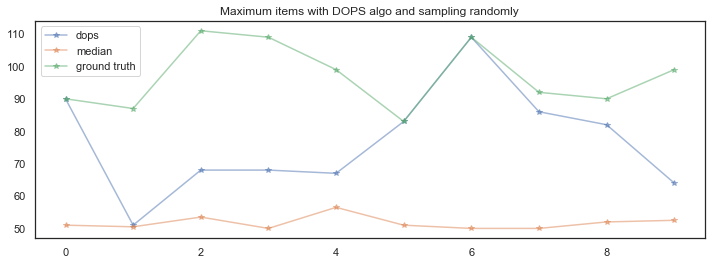

In [62]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,10), pred, '*-', alpha=0.5, label='dops')
plt.plot(np.arange(0,10), rand, '*-', alpha=0.5, label='median')
plt.plot(np.arange(0,10), real, '*-', alpha=0.5, label='ground truth')
plt.legend()
plt.title('Maximum items with DOPS algo and sampling randomly')
plt.show()